In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toxicity/train.csv


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv('/kaggle/input/toxicity/train.csv')
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Preprocess

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Create model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Bidirectional, Dense, Embedding

In [34]:
model = Sequential()

model.add(Input(shape=(1800,)))
model.add(Embedding(MAX_FEATURES+1, 32))

model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation='sigmoid'))

In [35]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [36]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 699s 100ms/step - loss: 0.0566 - val_loss: 0.0451
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 697s 100ms/step - loss: 0.0448 - val_loss: 0.0393
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 699s 100ms/step - loss: 0.0409 - val_loss: 0.0358
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 697s 100ms/step - loss: 0.0362 - val_loss: 0.0318
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 697s 100ms/step - loss: 0.0327 - val_loss: 0.0294
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 697s 100ms/step - loss: 0.0299 - val_loss: 0.0270
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 695s 100ms/step - loss: 0.0260 - val_loss: 0.0239
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 697s 100ms/step - loss: 0.0237 - val_loss: 0.0213
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 697s 100ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 696s 100ms/step - loss: 0.0199 - val_loss: 0.0168


In [39]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

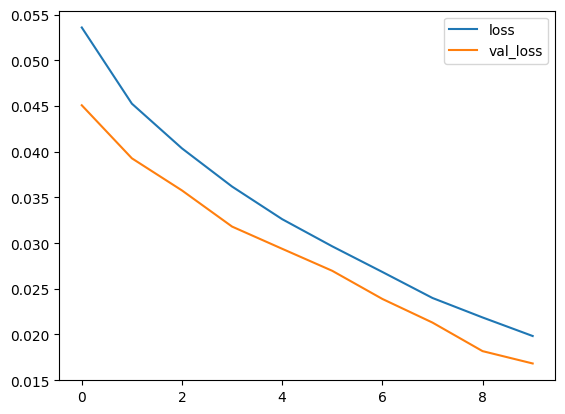

In [40]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## prediction

In [57]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [58]:
input_text.shape

TensorShape([1800])

In [59]:
# Reshape input_text to be 2D 
input_text = tf.expand_dims(input_text, 0) 

In [60]:
input_text.shape

TensorShape([1, 1800])

In [61]:
res = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [47]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [48]:
res

array([[0.99853134, 0.18107389, 0.98859954, 0.0220743 , 0.945264  ,
        0.03275119]], dtype=float32)

In [49]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [50]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1]])

In [51]:
model.predict(batch_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[2.48548487e-10, 0.00000000e+00, 6.59487151e-21, 4.44980889e-33,
        2.01549567e-18, 2.24979721e-31],
       [6.48206537e-08, 1.91047529e-34, 4.53009187e-15, 6.81278201e-22,
        4.75495836e-13, 5.36267694e-21],
       [1.80171048e-06, 1.11431541e-26, 2.77791180e-12, 1.02739511e-16,
        6.79771170e-11, 7.18609835e-16],
       [6.79057477e-10, 0.00000000e+00, 5.88883268e-19, 4.40056719e-26,
        6.16907542e-16, 9.65601050e-25],
       [2.15593550e-11, 0.00000000e+00, 1.49406557e-22, 1.01462456e-30,
        1.94691536e-19, 2.08297990e-29],
       [5.94396226e-07, 1.06472197e-30, 1.09535796e-12, 5.49935190e-18,
        1.07627095e-10, 1.01757383e-16],
       [4.12251637e-07, 3.75718275e-30, 1.35688097e-12, 6.79735404e-17,
        4.82584667e-11, 7.95741185e-16],
       [1.05647260e-07, 8.55810672e-34, 3.27286289e-15, 1.03433430e-19,
        6.13716326e-13, 1.19871023e-18],
       [3.15469286e-08, 2.41513034e-35, 6.75550958e-15, 5.01390165e-20,
        5.88764877e-13, 

## evaluation

In [63]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [64]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [65]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

In [66]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9159218072891235, Recall:0.9156660437583923, Accuracy:0.4924774467945099


## save

In [67]:
model.save('toxicity.h5')

In [83]:
vocab = vectorizer.get_vocabulary()

# Save the vocabulary to a file
with open("tv_vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

## 